In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
device = torch.device("cpu")

In [16]:
train_dataset = datasets.FashionMNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data',train=False,download=True,transform=transforms.ToTensor())

In [17]:
batch_size = 200
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [18]:
describe = {0:'T恤(T-shirt/top)',1:'裤子(Trouser)',2:'套头衫(Pullover)',3:'连衣裙(Dress)',4:'外套(Coat)',5:'凉鞋(Sandal)',6:'衬衫(Shirt)',7:'运动鞋(Sneaker)',8:'包(Bag)',9:'靴子(Ankle boot)'}

衬衫(Shirt)


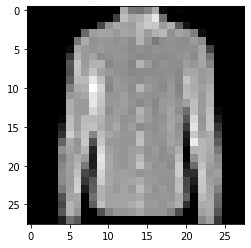

In [19]:
images,labels = next(iter(train_loader))
plt.imshow(images[0][0],cmap='gray')
print(describe[labels[0].item()])

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(7*7*256,512)
        self.fc2 = nn.Linear(512,150)
        self.out = nn.Linear(150,10)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x


In [21]:
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()

In [25]:
def get_accuracy(show=False):
    net.eval()
    correct = 0
    total = len(test_dataset)
    for i,(images,labels) in enumerate(test_loader):
        images = images.to(device)
        predict = torch.max(net(images),1).indices.tolist()
        correct += sum([1 for i in range(len(predict)) if predict[i]==labels[i]])
    if show:
        print(f"accuracy:{(correct/total)*100:.2f}%")
    return correct/total
get_accuracy(show=True)

accuracy:91.88%


0.9188

In [31]:
def start_training(epochs,learning_rate):
    max_accuracy = 0.9188
    for epoch in range(epochs):
        net.load_state_dict(torch.load('CNN-FashionMNIST.pkl'))
        net.train()
        total_loss = 0
        for i,(images,labels) in enumerate(train_loader):
            labels = labels.to(device)
            images = images.to(device)
            predict = net(images)
            loss = criterion(predict,labels)
            optimizer = optim.Adam(net.parameters(),lr=learning_rate)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        accuracy = get_accuracy()
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            print(f"epoch {epoch+1}, loss {total_loss}, accuracy {max_accuracy*100:.2f}%, saved!")
            torch.save(net.state_dict(),'CNN-FashionMNIST.pkl')
        else:
            print(f"epoch {epoch+1}, loss {total_loss}, accuracy {accuracy*100:.2f}%")


start_training(epochs=3,learning_rate=0.00001)

epoch 1, loss 187.51969525963068, accuracy 91.79%, saved!
epoch 2, loss 93.32476226985455, accuracy 91.88%, saved!
epoch 3, loss 88.39122143760324, accuracy 91.82%


Correct answer:运动鞋(Sneaker)
Predicted answer:运动鞋(Sneaker)


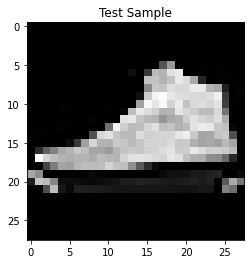

Correct answer:裤子(Trouser)
Predicted answer:裤子(Trouser)


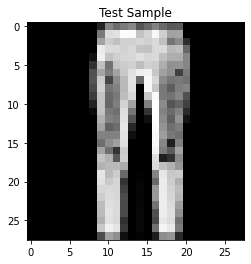

Correct answer:套头衫(Pullover)
Predicted answer:套头衫(Pullover)


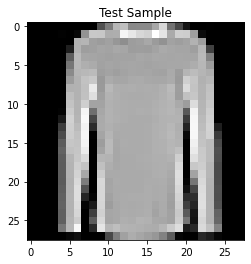

Correct answer:运动鞋(Sneaker)
Predicted answer:运动鞋(Sneaker)


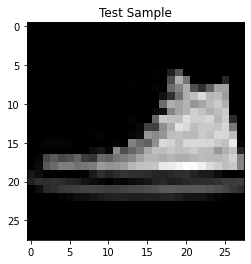

Correct answer:靴子(Ankle boot)
Predicted answer:靴子(Ankle boot)


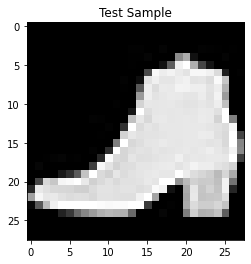

In [26]:
def show_prediction(num=1):
    net.load_state_dict(torch.load('CNN-FashionMNIST.pkl',map_location=device))
    net.eval()
    for i in range(num):
        image,label = next(iter(test_loader))
        plt.title("Test Sample")
        plt.imshow(image[0][0],cmap='gray')
        print(f"Correct answer:{describe[label[0].item()]}")
        print(f"Predicted answer:{describe[torch.max(net(image[0].reshape(1,1,28,28)),1).indices.item()]}")
        plt.show()

show_prediction(5)